# Initial data analysis on BeerAdvocate

In this notebook we investigate the structure of the data, execute data cleaning and do initial analysis on the dataset. We motivate and generate aspect based sentiment scores for some subset of reviews to demonstrate the usage of the model.

## Notebook outline
   * [Analysis on BeerAdvocate](#Analysis-on-BeerAdvocate)
        * [Understanding data structure](#Understanding-data-structure)
        * [Handling missing values](#Handling-missing-values)
        * [Checking for data inconsistencies](#Checking-for-data-inconsistencies)
        * [Initial data analysis](#Initial-data-analysis)
            * [Initial analysis on styles](#Initial-analysis-on-styles)
            * [Initial analysis on grading columns](#Initial-analysis-on-grading-columns)
            * [Initial analysis on grading over time](#Initial-analysis-on-grading-over-time)
                * [Days of the week analysis](#Days-of-the-week-analysis)
                * [Monthly analysis](#Monthly-analysis)
            * [Are grades for aspects similar per review?](#Are-grades-for-aspects-similar-per-review?)
            

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
DATA_PATH = './datasets/BeerAdvocate/'

## Analysis on BeerAdvocate

### Understanding data structure

In this section we load the reviews from pickles ratings and reviews and inspect what is the relation between these two datasets.
We load datasets of users, beers and breweries and inspect their structures.

#### Ratings and reviews

Load data from pickles. To obtain pickles run the notebook _data_import.ipynb_

In [3]:
# load Beer Advocate data from pickles
ratings = pd.read_pickle(DATA_PATH + 'ratings.pkl')
reviews = pd.read_pickle(DATA_PATH + 'reviews.pkl')

In [4]:
# inspect data size and show a few datapoints
print('Ratings - Rows: {}, columns {}'.format(ratings.shape[0], ratings.shape[1]))
print('Reviews - Rows: {}, columns {}'.format(reviews.shape[0], reviews.shape[1]))
reviews.sample(2)

Ratings - Rows: 8393032, columns 17
Reviews - Rows: 2589586, columns 17


,Beer Name,Beer Id,Brewery Name,Brewery Id,Style,Abv,Date,Username,User Id,Appearance,Aroma,Palate,Taste,Overall,Rating,Text,Review
1186019,Original Honey Brown Extra Rich Lager (Beer Br...,832,Genesee Brewing Co. / Dundee Brewing Co.,302,American Amber / Red Lager,4.5,2008-12-12 12:00:00,colts9016,colts9016.145888,3.0,3.0,2.5,3.0,3.0,2.95,Appearance: A dark amber color little to no he...,None
2556631,Carolina Blonde,920,Carolina Beer Company,354,American Blonde Ale,5.0,2003-09-27 12:00:00,RockyTopHeel,rockytopheel.2829,4.0,3.0,3.0,3.5,4.0,3.46,Carolina Blonde has a lot to live up to in a w...,None


Rating column is calculated as $Rating = 0.06 * Appearance + 0.24 * Aroma + 0.10 * Palate + 0.40 * Taste  + 0.20 * Overall$. 
Therefore the sorted (by weight) aspects are taste, smell, overall, feel and look. We should be aware of this linear dependence of columns when making conclusions.

For BeerAdvocate, we have two datasets ratings and reviews. Let's understand what do they represent and what are the differences between them. We can notice that the 'Review' column has None value for both sample rows from reviews dataframe. It turns out this is the case for each of the rows:

In [5]:
print('Reviews - count of None values in \'Review\' column: {}'.format(reviews['Review'].isna().sum()))

Reviews - count of None values in 'Review' column: 2589586


We can also observe that this value coincides with the count of 'True' values in 'Review' column of ratings dataframe:

In [6]:
print('Ratings - count of True values in \'Review\' column: {}'.format(ratings['Review'].sum()))

Ratings - count of True values in 'Review' column: 2589586


This hints us towards the conclusion that 'Review' column in ratings dataframe indicates wether textual review of beer exists. This however isn't the case, since we can observe that in ~120k rows textual review exists and column is set to False:

In [7]:
print('Ratings - count of non-empty texts values in \'Text\' column: {}'.format(ratings['Text'].notna().sum()))

Ratings - count of non-empty texts values in 'Text' column: 2715712


In [8]:
ratings[(ratings['Review']==False)&(ratings['Text'].notna())].head(2)

,Beer Name,Beer Id,Brewery Name,Brewery Id,Style,Abv,Date,Username,User Id,Appearance,Aroma,Palate,Taste,Overall,Rating,Text,Review
153,Sheelin Blonde Ale,153718,The Sheelin Brewery,32848,American Blonde Ale,NaN,2015-06-13 12:00:00,beerinabottle,beerinabottle.811533,4.25,4.25,4.50,4.75,4.50,4.53,500 ml bottle picked up in a visit to the home...,False
155,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2016-12-31 12:00:00,awjess,awjess.1185716,4.50,4.00,4.25,4.00,4.25,4.11,"Look - Has a nice foamy head, Feel - Creamy ...",False


Since all three values are the relatively close, it seems that the reviews dataset is a subset of ratings dataframe. We will now investigate this further.

First, we check if there are any duplicates in either of dataframes:

In [9]:
print('Duplicated rows in ratings : {}'.format(sum(ratings.duplicated())))
print('Duplicated rows in reviews : {}'.format(sum(reviews.duplicated())))

Duplicated rows in ratings : 0
Duplicated rows in reviews : 0


We will now confirm if each row from the Reviews dataframe also exists in the Ratings dataframe

In [10]:
# Since there are no duplicates in both dataframes, we compare the len of the intersection and the length of 
# the smaller dataframe. We obtain the intersection by merging between ratings and reviews
# We exclude only Review column for merge since it's None in reviews
assert len(ratings.merge(reviews, how='inner', on=ratings.columns.to_list()[:16])) == len(reviews)

Since the lengths are the same, we conclude the reviews dataframe is strict subset of ratings dataframe and we mostly focus the analysis on **reviews** dataframe, since we are interested in free-text reviews.

#### Users, beers and breweries

In [11]:
users = pd.read_csv(DATA_PATH + 'users.csv')
print("# of users: {} ".format(len(users)))
users.sample(2)

# of users: 153704 


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
132108,1,0,coreyrj.995563,CoreyRJ,1.433412e+09,"United States, New Jersey"
117645,8,1,rxleyland.711364,RxLeyland,1.357297e+09,"United States, Colorado"


In [12]:
beers = pd.read_csv(DATA_PATH + 'beers.csv')
print("# of beers: {} ".format(len(beers)))
beers.sample(2)

# of beers: 280823 


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
1876,224203,Dog E,16315,BrewDog,American Double / Imperial Stout,8,2,4.25,NaN,NaN,16.1,4.1975,NaN,0,NaN
210611,86814,Maracuja Imperial Lambic,16594,LagerHaus Grill & Brewery,Lambic - Fruit,2,1,4.39,NaN,NaN,14.0,4.5250,NaN,0,NaN


In [13]:
breweries = pd.read_csv(DATA_PATH + 'breweries.csv')
print("# of breweries: {} ".format(len(breweries)))
breweries.sample(2)

# of breweries: 16758 


,id,location,name,nbr_beers
12099,48089,"United States, North Carolina",White Labs,0
7121,35166,Netherlands,Kaapse Brouwers,45


### Handling missing values

We investigate whether there are missing values in reviews, users and breweries.

#### Reviews

In [14]:
#We always know which beer is rated, style of the beer, who rated the beer and when the beer is rated : 
assert len(reviews) == len(reviews[reviews['Beer Id'].notna()])
assert len(reviews) == len(reviews[reviews['Style'].notna()])
assert len(reviews) == len(reviews[reviews['User Id'].notna()])
assert len(reviews) == len(reviews[reviews['Date'].notna()])

###### How many datapoints do not have grades for certain aspects, total rating or text review?

We do this analysis on the full dataset (ratings).

In [15]:
# reviews (subset of ratings)
interesting_columns = ['Appearance','Aroma','Palate','Taste','Overall','Rating','Text']

display_df = {'Percentage of present entries (%)': 
    [100*len(reviews[reviews[column].notna()])/len(reviews) for column in interesting_columns], 
     'Variables': interesting_columns}

# create dataframe to display percentages of non-null values
power_stats_dataframe = pd.DataFrame.from_dict(data=display_df).set_index('Variables')
power_stats_dataframe.transpose().style.set_caption('Beer Advocate Reviews :').format(precision=3)

Variables,Appearance,Aroma,Palate,Taste,Overall,Rating,Text
Percentage of present entries (%),98.764,98.764,98.764,98.764,98.764,100.000,100.000


In the reviews, all the ratings have text and rating. There is a small percentage that doesn't have grades for other aspects. At this point we don't discard these datapoints.

The presence (%) of non-values for Appearance, Aroma, Palate, Taste and Overall are the same. Do they correspond to the same datapoints?

In [16]:
print('Reviews - Correspond to the same datapoints: ')
(reviews[reviews['Appearance'].isna()].equals(reviews[reviews['Aroma'].isna()])) and \
(reviews[reviews['Appearance'].isna()].equals(reviews[reviews['Taste'].isna()])) and \
(reviews[reviews['Appearance'].isna()].equals(reviews[reviews['Overall'].isna()]))

Reviews - Correspond to the same datapoints: 


True

We confirmed missing values correspond to the same reviews.

The conclusions : 
- there is small percentage of non-rated aspects
- the reviews that have an aspect missing, have all the aspects missing

#### Users, beers and breweries

We investigate the presence of missing values for the features of our interest. Namely, the location of users and breweries and the alcohol level (ABV) in beer.

In [17]:
print('Users with uknown location : {:.3f} %'.format(len(users[users['location'].isna()])/len(users)*100))
print('Breweries with uknown location : {:.3f} %'.format(len(breweries[breweries['location'].isna()])/len(breweries)*100))
print('Beers with uknown ABV : : {:.3f} %'.format(len(beers[beers['abv'].isna()])/len(beers)*100))

Users with uknown location : 20.350 %
Breweries with uknown location : 0.000 %
Beers with uknown ABV : : 12.828 %


We always know the location of the brewery. There is non-negligible number of beers with uknown Abv and non-negligible number of users with uknown location.

### Checking for data inconsistencies

In this section we observe are there reviews repetions or impossible feature values.

In [18]:
# Are there multiple reviews from the same user for the same beer? 
multiple_reviews = reviews.groupby(['Beer Id','User Id']).agg('count') > 1
if sum(multiple_reviews.any()) == 0:
    print('No repetitions for the same beer and user')

No repetitions for the same beer and user


In [19]:
# Is there an invalid rating (ie. not in range 1-5)?
assert len(reviews[(reviews['Appearance'] < 1) | (reviews['Appearance'] > 5)]) == 0
assert len(reviews[(reviews['Aroma'] < 1) | (reviews['Aroma'] > 5)]) == 0
assert len(reviews[(reviews['Taste'] < 1) | (reviews['Taste'] > 5)]) == 0
assert len(reviews[(reviews['Overall'] < 1) | (reviews['Overall'] > 5)]) == 0
assert len(reviews[(reviews['Rating'] < 1) | (reviews['Rating'] > 5)]) == 0

In [20]:
# Is there invalid ABVs? Most alcoholic beer in the world has ABV of 67.5%.
assert len(reviews[reviews['Abv'] < 0]) == 0
assert len(reviews[reviews['Abv'] > 70]) == 0

We can conclude that ratings and ABV values are consistent in the dataset.

## Initial data analysis

In this section:
- we take a brief look into grades of beers of different styles
- we perform general temporal analysis of grades of reviews

#### Initial analysis on styles
Each beer has its Style. Let's group the beers based on style and have a glane at the data.

In [21]:
# group by styles and take means (meaningful for given grades)
reviews_by_style = reviews.groupby('Style').mean().sort_values('Overall')
reviews_by_style
#reviews_by_style[['Abv', 'Appearance', 'Aroma', 'Palate', 'Taste', 'Overall', 'Rating']]

,Beer Id,Brewery Id,Abv,Appearance,Aroma,Palate,Taste,Overall,Rating
Style,,,,,,,,,
Low Alcohol Beer,31956.218192,2032.512182,0.597968,3.000137,2.566749,2.595395,2.525082,2.625000,2.587120
Light Lager,17856.315424,1235.20067,4.087630,2.512368,2.240667,2.416415,2.338357,2.656071,2.398906
American Malt Liquor,31798.391481,2109.482574,7.470050,2.882770,2.501213,2.702959,2.589509,2.695632,2.616072
Euro Strong Lager,28957.766329,3369.711149,8.231843,3.218546,2.869935,2.955441,2.819000,2.857112,2.877638
American Adjunct Lager,11708.084182,1908.012777,4.856642,2.854214,2.535443,2.788226,2.722557,2.957232,2.741665
...,...,...,...,...,...,...,...,...,...
Russian Imperial Stout,41034.813736,5822.344282,10.284634,4.201200,4.088503,4.098884,4.148977,4.067590,4.117956
American Wild Ale,101010.895211,12455.584441,7.281400,3.992019,4.081268,4.029354,4.108408,4.074859,4.081156
Quadrupel (Quad),36351.128563,4176.793527,10.632953,4.100852,4.123473,4.107912,4.188342,4.094184,4.141814


There are 104 beer styles. 
It seems that better rated beer styles have higher ABV. We can visualize it and calculate Pearson correlation coefficient between Overall ratings and Abv.

[This](http://www.theibfr2.com/RePEc/ibf/ijmmre/ijmmr-v15n1-2022/IJMMR-V15N1-2022-1.pdf) paper shows the correlation between higher alcohol level and better grades. Let's confirm that in our dataset.

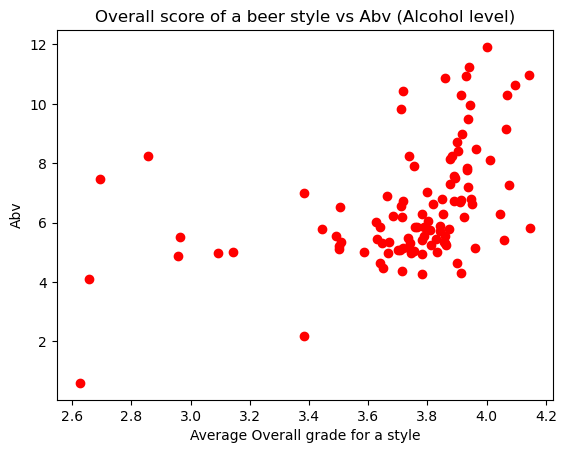

In [22]:
# plot overall vs alcohol level
plt.scatter(reviews_by_style['Overall'], reviews_by_style['Abv'],color='red')
plt.xlabel('Average Overall grade for a style')
plt.ylabel('Abv')
plt.title('Overall score of a beer style vs Abv (Alcohol level)')
plt.show()

We see that many beer styles have average ABV in range of 4-8%.

In [23]:
# capture linear dependence between grades and alcohol levels with pearson correlation coefficient
pearson_coef = scipy.stats.pearsonr(reviews_by_style['Overall'], reviews_by_style['Abv'])
pearson_coef

(0.4346396691383486, 4.0227441964919765e-06)

The Pearson correlation coefficient is 0.4346. The beers styles with higher ABV are more liked. 

#### Initial analysis on grading columns

People rated different aspects of beers, namely appearance, aroma, palate, taste and overall. We visually inspect what are the distributions of grades. We show only granularity by full grades, since people rarely gave grades which end on 0.25 or 0.75.

In [24]:
grading_columns = ['Appearance', 'Aroma', 'Palate', 'Taste', 'Overall', 'Rating'] #columns that are graded
colors = dict(zip(grading_columns,['green','red','blue','orange','magenta','gray'])) #separate color for each graded column

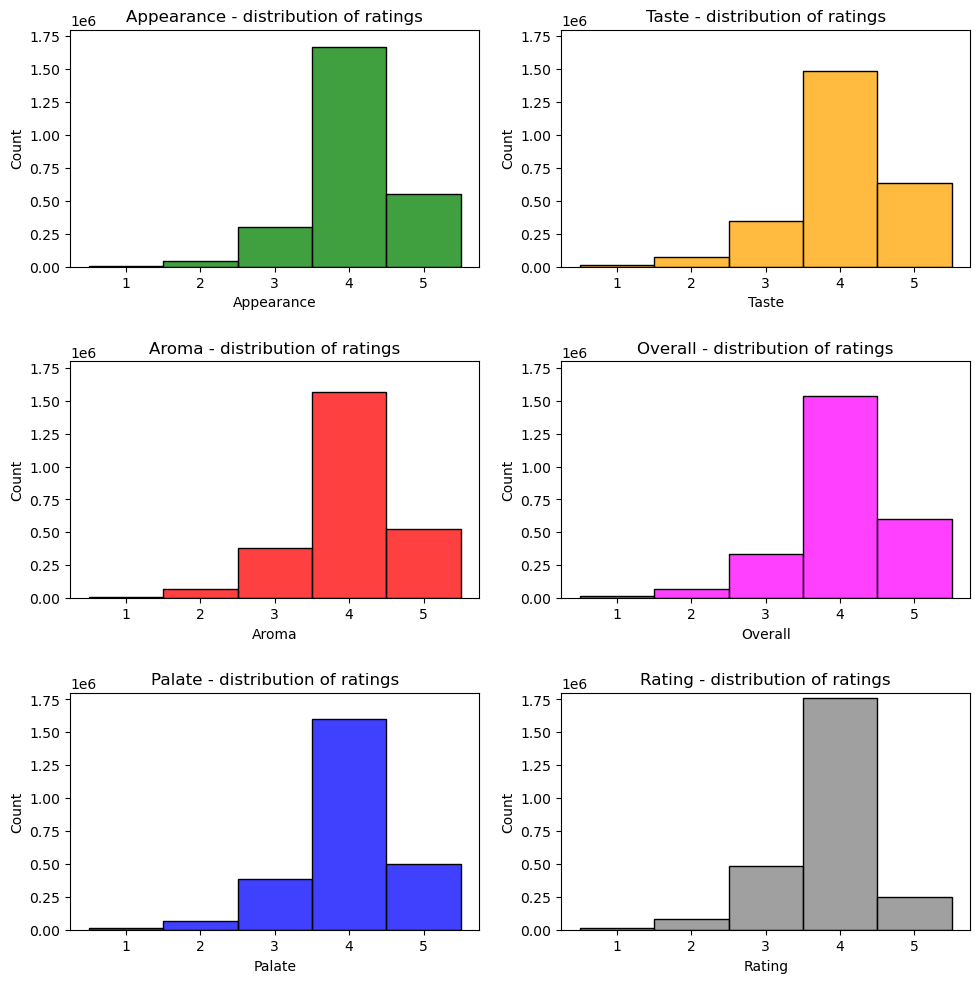

In [25]:
# one figure with multiple axes
fig, axes = plt.subplots(3,2)

    
for grading_index in range(len(grading_columns)):
    sns.histplot(ax=axes[grading_index%3, grading_index//3], data = reviews[grading_columns[grading_index]], discrete=True, color = colors[grading_columns[grading_index]])
    axes[grading_index%3, grading_index//3].set_ylim([0,1.8e6]) #set the same interval for y axis
    axes[grading_index%3, grading_index//3].set_title(grading_columns[grading_index] + ' - distribution of ratings')

# set figure size
fig.set_size_inches(9, 9)

# adjust spacing
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4)

We can observe that the distribution of ratings over different aspects is quite similar. Isn't it weird?

#### Initial analysis on grading over time

In this section we investigate temporal trends for user ratings. Namely, we add features that represent weekday and month in which the rating is given and we visualize the rating trends over time.

##### Days of the week analysis

In [26]:
reviews['Weekday'] = reviews['Date'].apply(lambda x: x.weekday()) #adding Weekday data

[Text(0.5, 1.0, 'Number of reviews per each day of the week')]

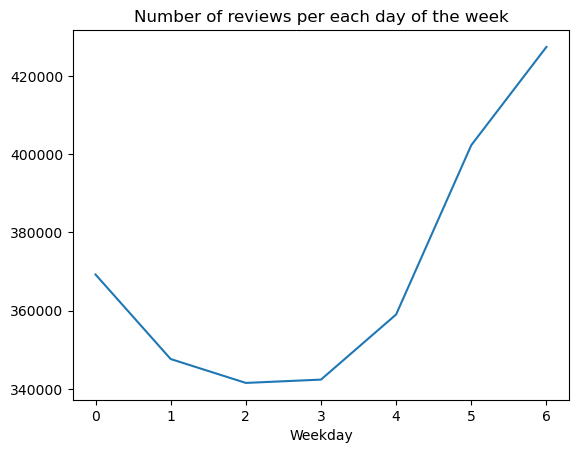

In [27]:
#Plotting number of reviews per each day of the week (to explore how active the users are)
sns.lineplot(data = reviews.groupby('Weekday').size()).set(title = 'Number of reviews per each day of the week')

Line plot indicates that the number of reviews during weekends is higher. The greatest number of reviews was written on Sundays, and the least number of reviews was written on Tuesdays:

In [28]:
print ('Sunday : {}'.format((reviews['Weekday']==6).sum())) #Total number of reviews written on Sundays
print ('Tuesday : {}'.format((reviews['Weekday']==2).sum())) #Total number of reviews written on Tuesdays

Sunday : 427485
Tuesday : 341508


We conclude that there are 25% more reviews given during Sundays, than during Tuesdays. It can be because users go more to parties or have more free time.

We will now investigate the ratings trend over the week.

In [29]:
reviews_by_weekday = reviews[grading_columns + ['Weekday']].groupby('Weekday').mean() #Mean of rating of each graded column
reviews_by_weekday

,Appearance,Aroma,Palate,Taste,Overall,Rating
Weekday,,,,,,
0,3.881407,3.795567,3.799598,3.837270,3.846429,3.829199
1,3.876397,3.788904,3.790816,3.826788,3.839819,3.821201
2,3.877436,3.788640,3.790875,3.828726,3.842240,3.822558
3,3.882183,3.791006,3.794766,3.831793,3.843892,3.825218
4,3.884315,3.792076,3.795879,3.833920,3.844856,3.826762
5,3.894303,3.801849,3.806776,3.843889,3.850008,3.835674
6,3.890663,3.802361,3.808417,3.847601,3.853737,3.837931


From the dataframe, we can notice the trend of ratings increasing towards the ending of the week. We will plot this data:

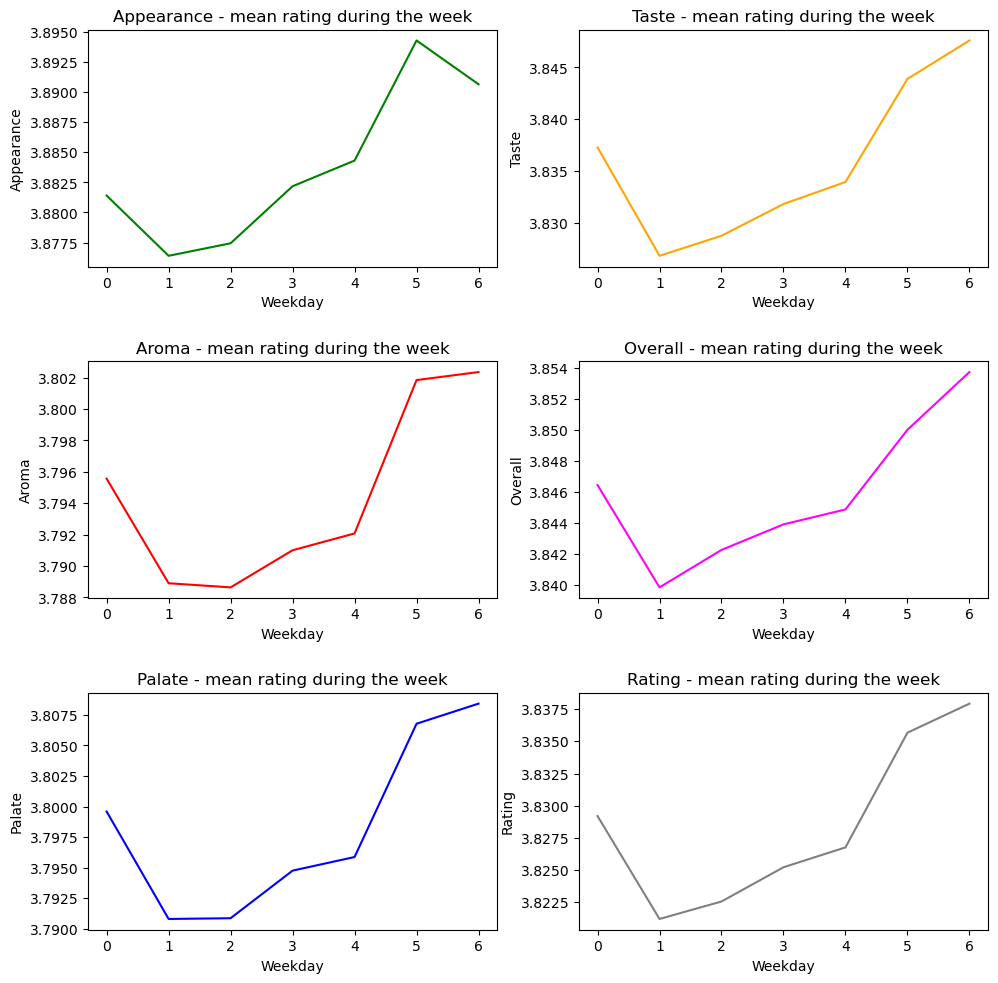

In [30]:
# one figure with multiple axes
fig, axes = plt.subplots(3,2)
    
for grading_index in range(len(grading_columns)):
    sns.lineplot(ax=axes[grading_index%3, grading_index//3], data = reviews_by_weekday[grading_columns[grading_index]], color = colors[grading_columns[grading_index]])
    axes[grading_index%3, grading_index//3].set_title(grading_columns[grading_index] + ' - mean rating during the week')
    

# set figure size
fig.set_size_inches(9, 9)

# adjust spacing
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4)

We notice there is a slight increase in grades towards the end of the week and monday. Notice that different plots have **different intervals for y axis**. This is because we want to visualize weekly trends rather than compare plots.

##### Monthly analysis

We will now do a similar anlyisis, but on a monthly basis:

In [31]:
reviews['Month'] = reviews['Date'].apply(lambda x: x.month) #adding Month data

[Text(0.5, 1.0, 'Number of reviews per month')]

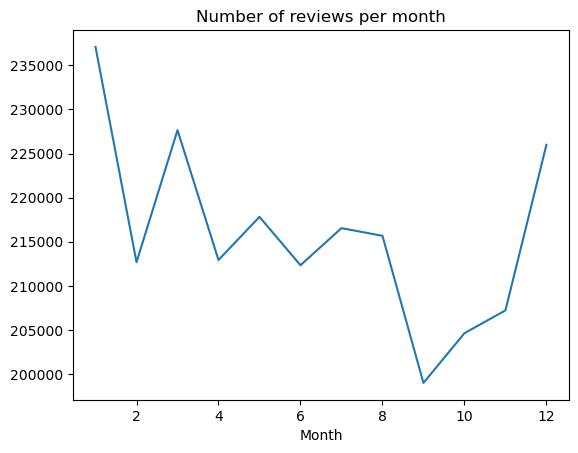

In [32]:
#Plotting number of reviews per each month
sns.lineplot(data = reviews.groupby('Month').size()).set(title = 'Number of reviews per month')

Users rate more during winter months! 

Have a glance at the dataframe obtained by grouping by month to see are differences between grades.

In [33]:
reviews_by_month = reviews[grading_columns + ['Month']].groupby('Month').mean()
reviews_by_month

,Appearance,Aroma,Palate,Taste,Overall,Rating
Month,,,,,,
1,3.900863,3.813498,3.811059,3.854263,3.860183,3.844949
2,3.904521,3.812238,3.817095,3.855734,3.863684,3.846816
3,3.903220,3.808227,3.813836,3.851204,3.859058,3.842652
4,3.899602,3.807837,3.814537,3.852042,3.860129,3.842994
5,3.883954,3.793214,3.804928,3.838762,3.851730,3.830600
6,3.870564,3.781304,3.793192,3.827318,3.839407,3.818769
7,3.864726,3.778248,3.789722,3.820357,3.833005,3.813176
8,3.865168,3.775078,3.781544,3.816919,3.831686,3.811377
9,3.866959,3.775777,3.781065,3.817010,3.831456,3.812626


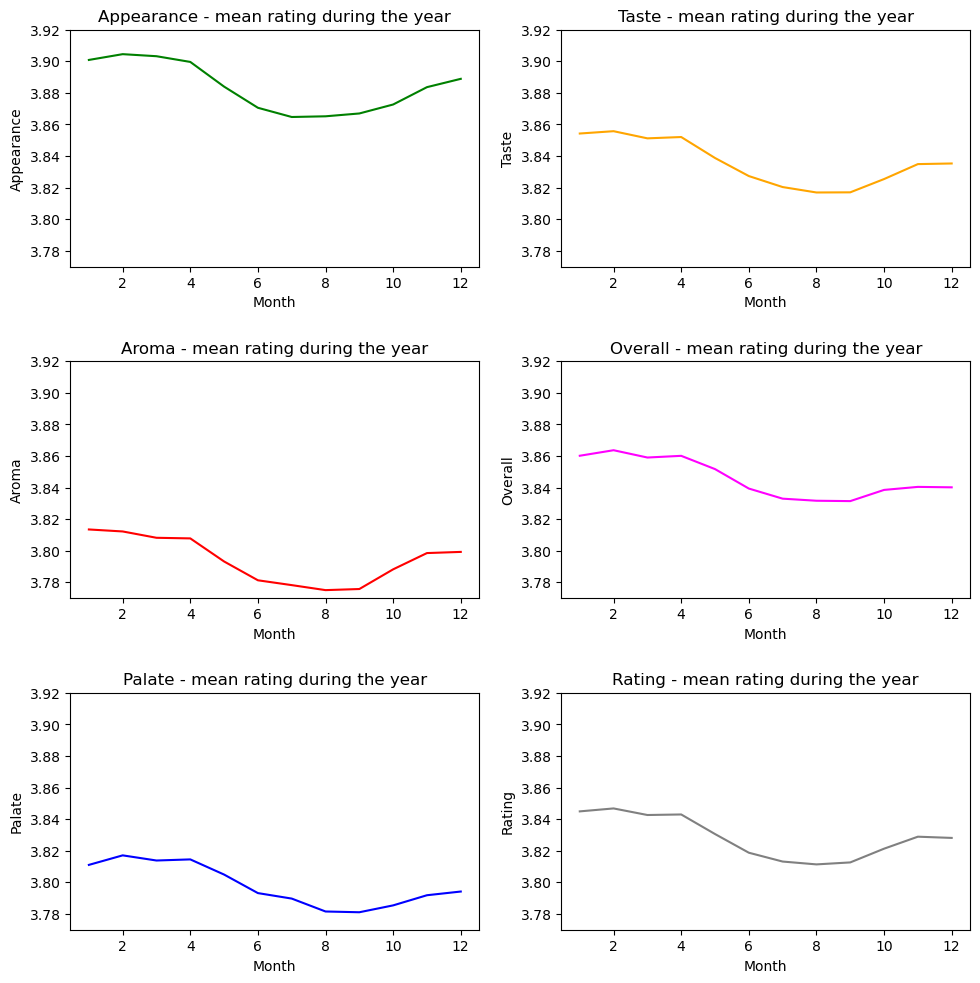

In [34]:
# one figure with multiple axes
fig, axes = plt.subplots(3,2)
    
for grading_index in range(len(grading_columns)):
    sns.lineplot(ax=axes[grading_index%3, grading_index//3], data = reviews_by_month[grading_columns[grading_index]], color = colors[grading_columns[grading_index]])
    axes[grading_index%3, grading_index//3].set_ylim([3.77,3.92]) #set the same interval for y axis
    axes[grading_index%3, grading_index//3].set_title(grading_columns[grading_index] + ' - mean rating during the year')
    

# set figure size
fig.set_size_inches(9, 9)

# adjust spacing
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4)

Conclusions of general trends:
- users rate more and better during weekends 
- users rate more and better during winter

#### Are grades for aspects similar per review?

How many ratings have the same or almost the same grades for the aspects?

In [35]:
# calculate incidents of all equal ratings
equal_ratings = sum((reviews['Appearance'] == reviews['Aroma']) & (reviews['Appearance'] == reviews['Palate']) &\
(reviews['Appearance'] == reviews['Taste']) & (reviews['Appearance'] == reviews['Overall']))
print('Equal ratings for all aspects : {}'.format(equal_ratings))
print('Percentage of all-equal ratings in the dataset : {:.2f}%'.format(100*equal_ratings/len(reviews)))

Equal ratings for all aspects : 190002
Percentage of all-equal ratings in the dataset : 7.34%


Let's define that a review has almost equal ratings if the grades for aspects differ for at most 0.5.

In [36]:
# calculate incidents of almost equal ratings
almost_equal_ratings = len(reviews[(reviews[['Appearance', 'Aroma', 'Palate', 'Taste', 'Overall']].max(axis=1) \
         - reviews[['Appearance', 'Aroma', 'Palate', 'Taste', 'Overall']].min(axis=1)) <= 0.5])
print('Almost-equal ratings for all aspects : {}'.format(almost_equal_ratings))
print('Percentage of almost-equal ratings in the dataset : {:.2f}%'.format(100*almost_equal_ratings/len(reviews)))

Almost-equal ratings for all aspects : 1434535
Percentage of almost-equal ratings in the dataset : 55.40%


From these results we conclude that many many reviews have all the ratings rated (almost) equaly!